In [1]:
import matplotlib.pyplot as plt
import numpy as np
import descwl_shear_sims.sim
import galsim
from descwl_shear_sims.sim.galaxy_catalogs import (
    WLDeblendGalaxyCatalog,
    read_wldeblend_cat,
    get_shifts, 
)
from descwl_shear_sims.sim import (
    FixedGalaxyCatalog,  # one of the galaxy catalog classes
    make_sim,  # for making a simulation realization
    make_psf,  # for making a simple PSF
    make_ps_psf
)


/opt/conda/lib/python3.8/site-packages/descwl_shear_sims/lsst_bits.py:33: UserWarning: the DM stack could not be imported to check the simulation bit mask flags
  warnings.warn(


In [2]:
class NumberedGalaxyCatalog(WLDeblendGalaxyCatalog):
    """
    generate a specific number of galaxies
    """
    def __init__(self, *, rng, coadd_dim, buff, ngal):
        self.gal_type = 'wldeblend'
        self.rng = rng

        self._wldeblend_cat = read_wldeblend_cat(rng)

        self.shifts = get_shifts(
            rng=rng,
            coadd_dim=coadd_dim,
            buff=buff,
            layout="random",
            nobj=ngal,
        )

        num = self.shifts.size
        self.indices = self.rng.randint(
            0,
            self._wldeblend_cat.size,
            size=num,
        )

        self.angles = self.rng.uniform(low=0, high=360, size=num)

        

In [3]:
class GalaxyObs:
    def __init__ (self, psf,data,data_true, data_xpsf, data_xipsf):
        self.psf = psf
        self.data = data
        self.data_true = data_true
        self.data_xpsf = data_xpsf
        self.data_xipfs = data_xipsf


    def bands(self):
        return "".join(self.psf.keys())
    
    def plot_rgb(self, what):
        if hasattr(what['g'],"drawImage"):
            ### this is not working are images are not the same shape
            print(what['g'].drawImage().array.shape,what['r'].drawImage().array.shape,what['i'].drawImage().array.shape)
            toplot=np.array([what['g'].drawImage().array,
                        what['r'].drawImage().array,
                        what['i'].drawImage().array])
            print(toplot.shape)
        else:
            toplot=np.array([what['g'].image.array,
                        what['r'].image.array,
                        what['i'].image.array])
        print (toplot.shape)
        plt.imshow(toplot.T,interpolation='nearest')

In [4]:
def GenerateCatalog (Ng=10,dim=10, rng=np.random.RandomState(111), bands='gri', fwhm_true=0.4, fwhm_sigma=0.1):


    psf0 = galsim.Gaussian(fwhm=fwhm_true)
    randomPSF = lambda : galsim.Gaussian(fwhm=np.random.uniform(0.4,1.0)).shear(
        g1=np.random.normal(0.0,fwhm_sigma),
        g2=np.random.normal(0.0,fwhm_sigma))

    outcat=[]
    
    for i in range(Ng):
        cat = NumberedGalaxyCatalog(
            rng=rng,
            coadd_dim=dim,
            buff=10,
            ngal=1,
        )
        psf={}
        psfi={}
        data={}
        data_true={}    

        for band in bands:
            psf[band] = randomPSF()
            #psfi[band] = psf[band].drawImage()
            data[band] = descwl_shear_sims.sim.make_sim(
                rng=rng,
                galaxy_catalog=cat,
                coadd_dim=dim,
                bands=[band],
                g1=0.0,g2=0.0,
                epochs_per_band=1,
                noise_factor=1.0,
                psf=psf[band],
            )['band_data'][band][0]
            data_true[band] = descwl_shear_sims.sim.make_sim(
                rng=rng,
                galaxy_catalog=cat,
                coadd_dim=dim,
                bands=[band],
                g1=0,g2=0,
                epochs_per_band=1,
                noise_factor=0.0,
                psf=psf0,
            )['band_data'][band][0]
        data_xpsf = None
        data_xipsf = None
        go = GalaxyObs(psf,data,data_true,data_xpsf, data_xipsf)
        outcat.append(go)
    return outcat


In [5]:
c = GenerateCatalog()

/opt/conda/lib/python3.8/site-packages/descwl_shear_sims/sim/sim.py:264: RuntimeWarning: divide by zero encountered in double_scalars
  weight.array[:, :] = 1.0/noise**2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 35, 35)
(3, 35, 35)


Text(0.5, 1.0, 'truth')

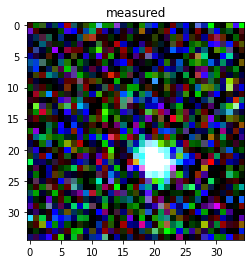

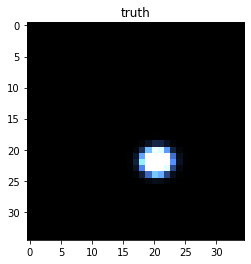

In [6]:
plt.figure()
c[0].plot_rgb(c[4].data)
plt.title('measured')
plt.figure()
c[0].plot_rgb(c[4].data_true)
plt.title('truth')